# Training SDSS Color Models

This notebook demonstrates how to load SDSS fluxes from PhotoObj files via the BLISS pipeline and fit gaussian mixture model color priors for both stars and galaxies.

In [112]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
import numpy as np
from os import environ
import torch
import pickle
from pathlib import Path
from astropy.io import fits
from hydra import initialize, compose
from hydra.utils import instantiate
import matplotlib.pyplot as plt

from bliss.simulator.prior import ImagePrior
from bliss.surveys.sdss import SloanDigitalSkySurvey, column_to_tensor, SDSSDownloader

In [114]:
environ["BLISS_HOME"] = str(Path().resolve().parents[1])
with initialize(config_path=".", version_base=None):
    cfg = compose("config")

# Retrieving raw ratios from disk via BLISS prior

We have SDSS flux information stored internally through PhotoObj FITS tables downloaded from the SDSS database. These are accessible by the SloanDigitalSkySurvey object. Note that these files are not stored within our repository. To correctly load ratios, specify a root sdss_dir directory that itself contains sub-directories specific to the desired run/camcol/field you would like to investigate (i.e. sdss_dir/run/camcol/field/photoObj_file(s)). 

In [120]:
def compute_flux_ratio(obj_fluxes, sdss_obj):
    """Query SDSS frames to get flux ratios in units of electron count.

    Args:
        obj_fluxes: tensor of electron counts for a particular SDSS object
        sdss_obj: SloanDigitalSkySurvey object entry for a particular field

    Returns:
        ratios (Tensor): Ratio of electron counts for each light source in field
        relative to r-band
    """
    ratios = torch.zeros(obj_fluxes.size())

    sdss_bands = ["u", "g", "r", "i", "z"]

    # distribution of nelec_per_nmgy very clustered around mean
    nelec_per_nmgys = sdss_obj["nelec_per_nmgy_list"]
    r_rat = nelec_per_nmgys[2].mean()  # fix r-band (count:nmgy) ratio
    nelec_per_nmgy_r = nelec_per_nmgys[2].mean()

    for i in range(len(sdss_bands)):
        # distribution of nelec_per_nmgy very clustered around mean
        nelec_per_nmgy_rat = nelec_per_nmgys[i].mean() / r_rat

        # (nmgy ratio relative to r-band) * (nelec/nmgy ratio relative to r band)
        # result: ratio of fluxes in nmgys
        ratios[i] = np.log(obj_fluxes[i] / obj_fluxes[2])

    return ratios, nelec_per_nmgy_r

In [121]:
def load_color_distribution(sdss_fields, sdss_dir):

    rcf_stars_rest = {}
    rcf_gals_rest = {}

    # load SDSS object to iterate over field frames
    sdss = SloanDigitalSkySurvey(sdss_dir=sdss_dir, sdss_fields=sdss_fields, prior_config=cfg.surveys.sdss.prior_config, psf_config=cfg.surveys.sdss.psf_config)

    star_r_rats = []
    gal_r_rats = []

    # load all star, galaxy fluxes relative to r-band required for sampling
    for field_params in sdss_fields:
        run = field_params["run"]
        camcol = field_params["camcol"]
        fields = field_params["fields"]

        # load project SDSS dir
        sdss_path = Path(sdss_dir)

        for i, field in enumerate(fields):
            # Set photoObj file path
            # NOTE: This is the necessary directory structure!
            field_dir = sdss_path / str(run) / str(camcol) / str(field)
            po_path = field_dir / f"photoObj-{run:06d}-{camcol:d}-{field:04d}.fits"

            if not po_path.exists():
                SDSSDownloader(run, camcol, field, str(sdss_path)).download_po()
            msg = (
                f"{po_path} does not exist. "
                + "Make sure data files are available for fields specified in config."
            )
            assert Path(po_path).exists(), msg
            po_fits = fits.getdata(po_path)

            # retrieve object-specific information for ratio computing
            objc_type = column_to_tensor(po_fits, "objc_type").numpy()
            thing_id = column_to_tensor(po_fits, "thing_id").numpy()

            # mask fluxes based on object identity & validity
            galaxy_bools = (objc_type == 3) & (thing_id != -1)
            star_bools = (objc_type == 6) & (thing_id != -1)
            star_fluxes = column_to_tensor(po_fits, "psfflux") * star_bools.reshape(-1, 1)
            gal_fluxes = column_to_tensor(po_fits, "cmodelflux") * galaxy_bools.reshape(-1, 1)
            fluxes = star_fluxes + gal_fluxes

            # containers for light source ratios in current field
            star_fluxes_rest = []
            gal_fluxes_rest = []

            # SDSS object for current field
            sdss_obj = sdss[i]

            for obj, _ in enumerate(objc_type):
                if thing_id[obj] != -1 and torch.all(fluxes[obj] > 0):
                    ratios, nelecpernmgy_r = compute_flux_ratio(fluxes[obj], sdss_obj)
                    if objc_type[obj] == 6:
                        star_fluxes_rest.append(ratios)
                        star_r_rats.append(nelecpernmgy_r)
                    elif objc_type[obj] == 3:
                        gal_fluxes_rest.append(ratios)
                        gal_r_rats.append(nelecpernmgy_r)

            if star_fluxes_rest:
                rcf_stars_rest[(run, camcol, field)] = star_fluxes_rest
            if gal_fluxes_rest:
                rcf_gals_rest[(run, camcol, field)] = gal_fluxes_rest
    return rcf_stars_rest, rcf_gals_rest, star_r_rats, gal_r_rats

Running load_color_distribution gives us our star/galaxy ratios read directly from SDSS PhotoObj tables that will be used to fit our color models. 

Note: These ratios are relative to the r-band.

In [122]:
# load color distributions from sdss files
fields = [{"run": 94, "camcol": 1, "fields": list(np.arange(12, 492, 10, dtype=int))}, {"run": 125, "camcol": 1, "fields": list(np.arange(15, 575, 10, dtype=int))}, {"run": 752, "camcol": 1, "fields": list(np.arange(15, 695, 10))}, {"run": 3900, "camcol": 6, "fields": list(np.arange(16, 606, 10, dtype=int))}]
star_rats, gal_rats, star_r_rats, gal_r_rats = load_color_distribution(fields, "/data/sdss")

In [123]:
star_r_rats_np = np.array(star_r_rats)
print(star_r_rats_np.mean())
gal_r_rats_np = np.array(gal_r_rats)
print(gal_r_rats_np.mean())

985.81586
987.1391


We store these ratios as Numpy arrays for convenience.

In [124]:
# convert dictionary tensor entries to one large list

star_ratios_list = []
gal_ratios_list = []

for _, values in star_rats.items():
    for tens in values:
        star_ratios_list.append(list(tens))


for _, values in gal_rats.items():
    for tens in values:
        gal_ratios_list.append(list(tens))

In [125]:
# convert to numpy arrays
import numpy as np

star_ratios_np = np.array(star_ratios_list)
gal_ratios_np = np.array(gal_ratios_list)

In [127]:
# cache ratio arrays via pickle
import pickle

with open('star_ratios_multi_field.pkl', 'wb') as f:
    pickle.dump(star_ratios_np, f)
with open('gal_ratios_multi_field.pkl', 'wb') as f:
    pickle.dump(gal_ratios_np, f)

# Loading raw ratios from cache

Once the above section has been completed, we now have SDSS flux ratios in cache. These can be now simply be loaded from disk. Note that the loaded file is in a different location than in which it was saved.

In [128]:
# load cached ratios via pickle
# with open("data/sdss/precomputed_ratios/star_ratios_multi_field_nelec.pkl", 'rb') as f:
with open("star_ratios_multi_field.pkl", 'rb') as f:
    star_ratios_base = pickle.load(f)

# with open("data/sdss/precomputed_ratios/gal_ratios_multi_field_nelec.pkl", 'rb') as f:
with open("gal_ratios_multi_field.pkl", 'rb') as f:
    gal_ratios_base = pickle.load(f)

We will only train our GMMs on the informative ratios, removing the R/R band ratios from both arrays.

In [129]:
star_ratios_np = np.concatenate((star_ratios_base[:, :2], star_ratios_base[:, 3:]), axis=1)
gal_ratios_np = np.concatenate((gal_ratios_base[:, :2], gal_ratios_base[:, 3:]), axis=1)

# Fitting Star GMM

With our loaded ratios, we can now fit a gaussian mixture model color prior for sampling colors to be used when generating simulated images. 

In [130]:
# remove outlier ratios to prevent skewed fitting
def filter_ratios(ratios_np, min_threshold):

    filtered_ratios_np = ratios_np[(np.median(ratios_np, axis=1) > min_threshold)]
    percent_kept = filtered_ratios_np.shape[0] / ratios_np.shape[0]
    print(f"{percent_kept*100}% kept")

    return filtered_ratios_np

For assurance, we fit a series of models by cross-validation (k = 5) and determine the best model based on the average log-likelihood of the data given the model.

In [131]:
star_ratios_np.mean()

-0.3938754

In [139]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.mixture import GaussianMixture

filtered_star_ratios_np = filter_ratios(star_ratios_np, -0.375)

# Tune these!
# ----------------
min_components = 1
max_components = 5
niter = 5
# ----------------

comps = np.linspace(min_components, max_components, niter, dtype=int)
params = {"n_components": comps}
gmm_log_likelihood_score = lambda estimator, X: -estimator.score(X) # minimize BIC
cv = GridSearchCV(GaussianMixture(), params, verbose=1, scoring=gmm_log_likelihood_score)
cv.fit(filtered_star_ratios_np)

84.29319371727748% kept
Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(estimator=GaussianMixture(),
             param_grid={'n_components': array([1, 2, 3, 4, 5])},
             scoring=<function <lambda> at 0x7fc938c0ee60>, verbose=1)

We can plot the results of our cross-validation experiment. 25 Gaussian components appears to maximize the log-likelihood for the star color model.

Text(0.5, 1.0, 'Cross validated results for fitting star color prior')

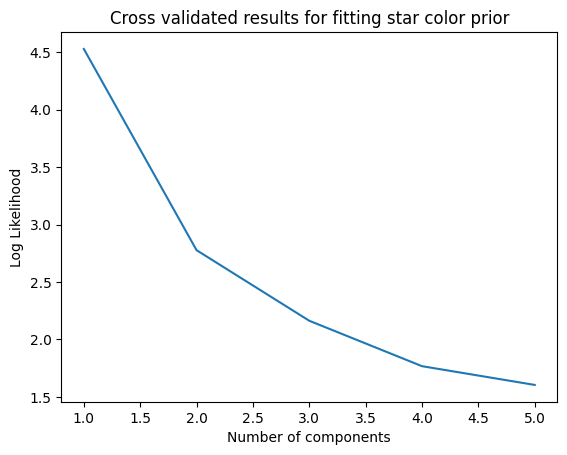

In [140]:
import matplotlib.pyplot as plt

scores = cv.cv_results_['mean_test_score']
plt.plot(comps, scores)
plt.xlabel('Number of components')
plt.ylabel('Log Likelihood')
plt.title('Cross validated results for fitting star color prior')

### Testing Star GMM

Rather than fit to 25 components, we will use 64 components for the BLISS prior - this is a generous number of coefficients but should be no worse than fitting to a smaller number of components. We can predict the labels for this model given the test set to investigate the subsequent assignments visually.

In [141]:
# evaluate best-fitting star color prior on test set
star_train, star_test = train_test_split(filtered_star_ratios_np, test_size=0.2)
n_comps = 64  # BLISS standard
gm_star = GaussianMixture(n_components=n_comps).fit(star_train)
labels = gm_star.predict(star_test)

Let's visually inspect the mixture coefficients. We don't expect a very even distribution over each component. 

In [31]:
gm_star.weights_

array([4.03885768e-02, 4.45459310e-02, 3.61412982e-03, 2.44424242e-02,
       1.73821246e-02, 9.66796159e-04, 7.02240112e-02, 3.32509834e-02,
       3.66268008e-03, 1.56361831e-02, 2.96604062e-03, 4.27066463e-04,
       7.30648736e-03, 3.31461509e-03, 3.54235208e-02, 3.37286274e-02,
       5.77134323e-03, 6.88315396e-03, 5.30183696e-03, 9.87055797e-03,
       9.15583224e-05, 1.29683363e-02, 3.35669421e-02, 1.94468473e-02,
       2.83507942e-02, 5.21208073e-02, 4.52040135e-03, 1.66291690e-02,
       1.14181693e-03, 8.82061140e-03, 2.33979215e-02, 1.33971584e-03,
       2.35682600e-02, 1.41637669e-03, 2.07276333e-02, 2.24715705e-04,
       3.14817242e-03, 1.42634721e-03, 6.10388818e-05, 1.47826890e-02,
       1.19626839e-02, 1.75363620e-02, 3.97901228e-03, 5.02845814e-02,
       9.15583227e-05, 6.17026946e-02, 2.64564871e-02, 1.54348354e-03,
       6.49402813e-03, 6.10388818e-05, 2.48129366e-02, 1.52250444e-03,
       1.72024959e-02, 2.10218774e-03, 8.15263554e-03, 2.15826381e-03,
      

We see that only ~7 components have a noteworthy coefficient.

In [142]:
# Creating figure
def plot_components(gmm, labels, k, data, leg, type):
    """Plot points belonging to top-k components"""

    plt.figure().clear()

    weights = np.copy(gmm.weights_)
    x = np.argpartition(weights, -k)[-k:]

    d = {}
    for i in x:
        d[f"comp #{i}"] = data[labels == i]

    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")
    
    # Creating plot
    for i, key in enumerate(d.keys()):
        l = d[key]
        ax.plot(l[:, 1], l[:, 2], l[:, 0], ".", label=key)
    # ax.margins(x=-0.45, y=-0.45, z=-0.25)
    # plt.axis([0, 1.5, 0, 15])
    if type == "star":
        plt.title("3-D visualization of star flux ratios relative to R and their assigned color")
    elif type == "gal":
        plt.title("3-D visualization of gal flux ratios relative to R and their assigned color")
    ax.set_xlabel('G-Band ratio')
    ax.set_ylabel('I-Band ratio')
    ax.set_zlabel('Z-Band ratio')

    if leg:
        ax.legend()
    
    # show plot
    plt.show()

<Figure size 640x480 with 0 Axes>

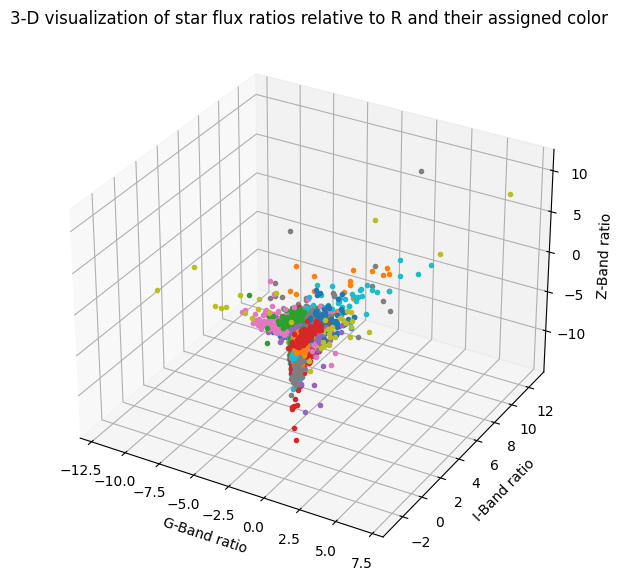

In [143]:
plot_components(gm_star, labels, n_comps, star_test, False, "star")

Several point clouds are layered on top of each other in three-dimensional space (plotting only G, I and Z bands). Note that the more dispersed point clouds have a very low mixture coefficient.

If we restrict the labeled points to only those belonging to the twelve components with the highest mixture coefficients, we start to weed through the overlaid points.

<Figure size 640x480 with 0 Axes>

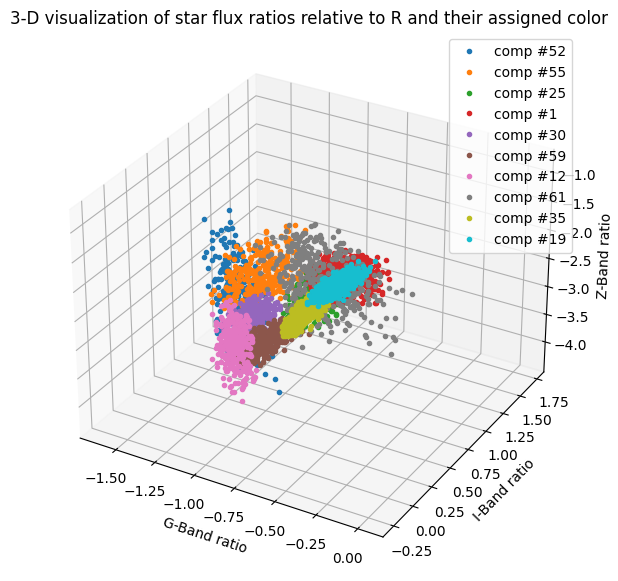

In [144]:
plot_components(gm_star, labels, 10, star_test, True, type="star")

# Fitting Gal GMM

We can do the same for our galaxy color prior!

In [148]:
filtered_gal_ratios_np = filter_ratios(gal_ratios_np, -0.4)

# Tune these!
# ---------------------
min_components = 1
max_components = 12
niter = 6
# ---------------------

comps = np.linspace(min_components, max_components, niter, dtype=int)
params = {"n_components": comps, "reg_covar": np.array([1e-4])}
gmm_log_likelihood_score = lambda estimator, X: -estimator.score(X)
cv = GridSearchCV(GaussianMixture(), params, verbose=1, scoring=gmm_log_likelihood_score)  # uses estimator.score by default, which is log likelihood for GMM
cv.fit(filtered_gal_ratios_np)

85.80335534681488% kept
Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=GaussianMixture(),
             param_grid={'n_components': array([ 1,  3,  5,  7,  9, 12]),
                         'reg_covar': array([0.0001])},
             scoring=<function <lambda> at 0x7fc938c94550>, verbose=1)

Text(0.5, 1.0, 'Cross validated results for fitting galaxy color prior')

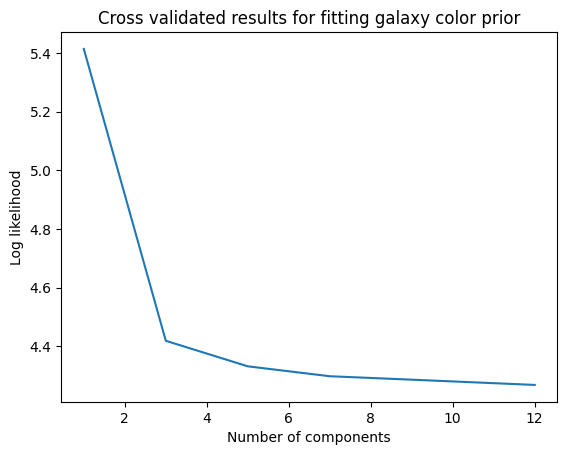

In [149]:
scores = cv.cv_results_['mean_test_score']
plt.plot(comps, scores)
plt.xlabel('Number of components')
plt.ylabel('Log likelihood')
plt.title('Cross validated results for fitting galaxy color prior')

Here, 45 components appears to maximize the log-likelihood metric.

### Testing Gal GMM

We can further test this model visually as before, using a standard 64 components.

In [150]:
gal_train, gal_test = train_test_split(filtered_gal_ratios_np, test_size=0.2)
n_comps = 64
gm_gal = GaussianMixture(n_components=64).fit(gal_train)
labels = gm_gal.predict(gal_test)

<Figure size 640x480 with 0 Axes>

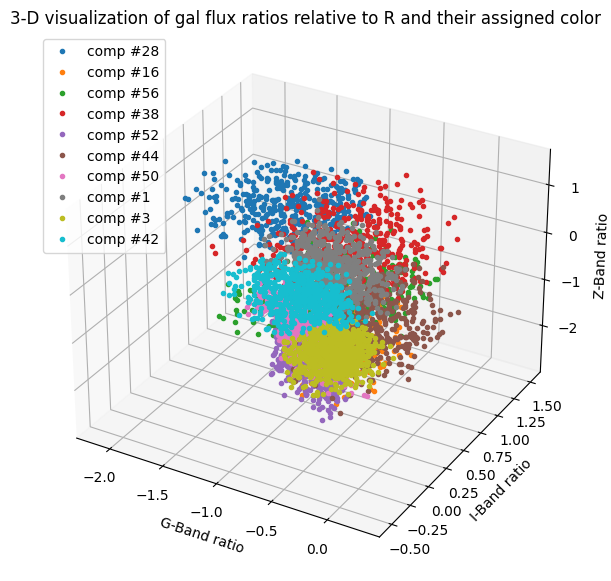

In [151]:
plot_components(gm_gal, labels, 10, gal_test, leg=True, type="gal")

This plot may appear surprising, but further inspection shows that the mixture coefficients corresponding to components #0 and #1 are 5 and 4 orders of magnitude larger than the rest, respectively.

### Saving best Gal/Star Color Models

Following training/evaluation, we save these models to disk via pickle to use for sampling color priors!

In [152]:
# save best-performing color models via pickle
star_file = "star_gmm_nmgy.pkl"
gal_file = "gal_gmm_nmgy.pkl"

with open(star_file, 'wb') as f:
    pickle.dump(gm_gal, f)

with open(gal_file, 'wb') as f:
    pickle.dump(gm_star, f)